# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [1]:
!unzip lenta-ru-news.csv.zip

Archive:  lenta-ru-news.csv.zip
  inflating: lenta-ru-news.csv       
  inflating: __MACOSX/._lenta-ru-news.csv  


In [2]:
!pip install pandas scikit-learn matplotlib

     |████████████████████████████████| 9.5 MB 11.9 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 52.8 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 25.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 50.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 37.4 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Сверточные нейронные сети

Несколько полносвязных слоев (с нелинейностями посередине) - это уже полноценная нейронная сеть. Однако это скорее какая-то базовая вещь. Действительно нужен полносвязный слой только в конце сети, а в качестве основных используются сверточные или рекуррентные слои. Главное их отличие (=преимущество) - учитывание структукры данных. В этом семинаре мы попробуем использовать сверточные сети. Лучше всего они работают в картинках, но для текстов их тоже можно применять (они быстрее рекуррентных и могут лучше работать на длинных последовательностях).

Про то как работают сверточные слои посмотрите в этом видео - https://www.youtube.com/watch?v=bNb2fEVKeEo

Основная идея - использовать много небольших (сильно меньше размера текста или картинки) матриц, которые применяются к кусочкам векторизованного текста/картинки. Между кусочком и матрицей считается близость, и эта близость передается дальше по сети. Т.е. кусочек как-бы **сворачивается** в одно число. 

Эти небольшие матрицы обучаются на данных и, например, для картинок в них собираются различные паттерны, важные для задачи. Например, для определения рукописных цифр, такие матрицы могут представлять горизонтальные черточки, волнистые линии, кружки и т.д. Есть даже целое направление исследований, которое занимается визуализацией и интерпретацией обученных сверток.

Из-за того, что матрицы применяются к кусочкам, а не отедльным элементам, гораздо лучше учитывается структура. 

## Классификация с помощью CNN

Давайте посмотрим, как в тензорфлоу использовать сверточные сети и как их соединять с Embedding и Dense слоями.

In [3]:
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# data = pd.read_csv('lenta-ru-news.csv').sample(frac=0.2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
# data.dropna(subset=['topic', 'text'], inplace=True)

In [30]:
# data.to_csv('lenta_sample.csv', index=None)

In [31]:
data = pd.read_csv('lenta_sample.csv')

Предобработка нам тут особо не важна.

In [7]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

In [8]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Предобработка точно такая же

In [9]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [10]:
len(vocab)

670782

In [11]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [12]:
len(filtered_vocab)

55293

In [13]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [14]:
id2word = {i:word for word, i in word2id.items()}

In [15]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [16]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [17]:
MEAN_LEN = np.median([len(x) for x in X])

In [18]:
MAX_LEN, MEAN_LEN

(3578, 170.0)

In [19]:
MAX_LEN = int(MEAN_LEN + 30)

In [20]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [21]:
X.shape

(147852, 200)

In [22]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [23]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [24]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

Для сравнения сначала обучим сеть только с помощью Dense слоев.

In [26]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )
mean = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(30, activation='relu')(mean)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              # фмеры тут нет, но есть точность и полнота по отдельности, 
              # и есть полнота при заданном пороге точности
              # name тут нужен для удобства,
              # иначе метрика будет называться типа "Precision_i"
              # и придется менять i в дальнейших визуализациях 
              metrics=[tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])



In [27]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
71/71 [==============================] - 5s 54ms/step - loss: 2.5193 - rec@prec: 0.0019 - val_loss: 1.5970 - val_rec@prec: 0.1969
Epoch 2/5
71/71 [==============================] - 3s 42ms/step - loss: 1.3394 - rec@prec: 0.4452 - val_loss: 0.8981 - val_rec@prec: 0.6848
Epoch 3/5
71/71 [==============================] - 3s 42ms/step - loss: 0.7545 - rec@prec: 0.7627 - val_loss: 0.7005 - val_rec@prec: 0.7841
Epoch 4/5
71/71 [==============================] - 3s 42ms/step - loss: 0.5140 - rec@prec: 0.8828 - val_loss: 0.6365 - val_rec@prec: 0.8173
Epoch 5/5
71/71 [==============================] - 3s 42ms/step - loss: 0.3629 - rec@prec: 0.9446 - val_loss: 0.6273 - val_rec@prec: 0.8156


dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


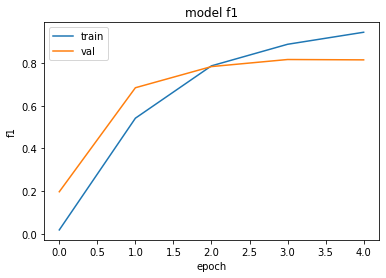

In [28]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

А теперь попробуем со сверточным слоем. В керасе они называются Conv1D (2D тоже есть, они используются для картинок). Их нужно ставить сразу после Embedding слоя.

In [77]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# все остальное точно такое же
# возвращает сверточный слой тоже последовательность векторов слегка измененной или такой же длины
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=128, strides=5)(embeddings)

# выход со сверточного слоя также можно просто конкатенировать
concat = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [78]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 201)]             0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 201, 30)           1659180   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 39, 128)           38528     
_________________________________________________________________
flatten_7 (Flatten)          (None, 4992)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                319552    
_________________________________________________________________
dense_15 (Dense)             (None, 19)                1235      
Total params: 2,018,495
Trainable params: 2,018,495
Non-trainable params: 0
_________________________________________________

In [79]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=5)

Epoch 1/5
141/141 [==============================] - 8s 44ms/step - loss: 2.1177 - f1: 0.1492 - rec@prec: 0.1014 - val_loss: 0.9621 - val_f1: 0.6896 - val_rec@prec: 0.6129
Epoch 2/5
141/141 [==============================] - 5s 38ms/step - loss: 0.7510 - f1: 0.7637 - rec@prec: 0.7556 - val_loss: 0.7174 - val_f1: 0.7744 - val_rec@prec: 0.7629
Epoch 3/5
141/141 [==============================] - 5s 38ms/step - loss: 0.4071 - f1: 0.8754 - rec@prec: 0.9221 - val_loss: 0.7081 - val_f1: 0.7906 - val_rec@prec: 0.7851
Epoch 4/5
141/141 [==============================] - 5s 38ms/step - loss: 0.2123 - f1: 0.9410 - rec@prec: 0.9791 - val_loss: 0.8861 - val_f1: 0.7800 - val_rec@prec: 0.7626
Epoch 5/5
141/141 [==============================] - 5s 38ms/step - loss: 0.0864 - f1: 0.9800 - rec@prec: 0.9965 - val_loss: 1.1194 - val_f1: 0.7797 - val_rec@prec: 0.7587


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


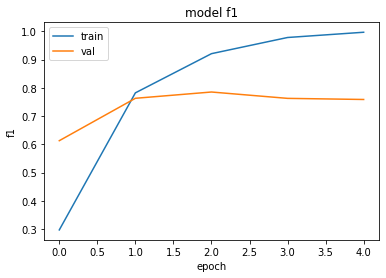

In [80]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


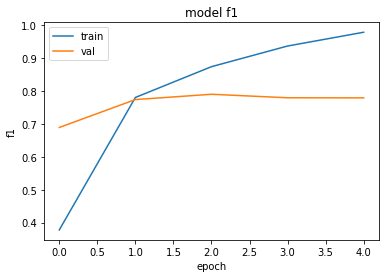

In [81]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Сверточные слои можно накладывать друг на друга.

Давайте еще разберем параметры:  
    **kernel_size** - это размер кусочков, к которым мы применяем сверточные матрицы (похоже на размер нграмма)   
    **filters** - количество матриц свертки  (это как бы размерность до которой будет сжат или развернут вектор)    
    **stride** - шаг по которому выбираются кусочки из последовательности (это как параметр шаг в функции range в питоне)  

In [82]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
concat = tf.keras.layers.Flatten()(conv2)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1])


In [83]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 201)]             0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 201, 100)          5530600   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 197, 32)           16032     
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 193, 32)           5152      
_________________________________________________________________
flatten_8 (Flatten)          (None, 6176)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                395328    
_________________________________________________________________
dense_17 (Dense)             (None, 19)                1235

In [84]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=5)

Epoch 1/5
71/71 [==============================] - 14s 174ms/step - loss: 2.2801 - f1: 0.0609 - val_loss: 1.1753 - val_f1: 0.6315
Epoch 2/5
71/71 [==============================] - 12s 167ms/step - loss: 0.9642 - f1: 0.6986 - val_loss: 0.7664 - val_f1: 0.7607
Epoch 3/5
71/71 [==============================] - 12s 167ms/step - loss: 0.5140 - f1: 0.8425 - val_loss: 0.7034 - val_f1: 0.7917
Epoch 4/5
71/71 [==============================] - 12s 166ms/step - loss: 0.2918 - f1: 0.9170 - val_loss: 0.8021 - val_f1: 0.7897
Epoch 5/5
71/71 [==============================] - 12s 170ms/step - loss: 0.1633 - f1: 0.9564 - val_loss: 1.0091 - val_f1: 0.7790


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


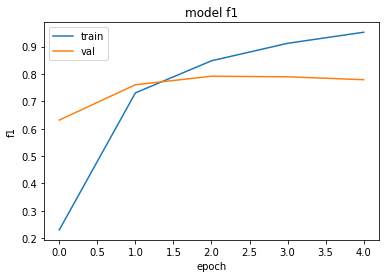

In [86]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Со сверточными слоями часто используется Pooling. Это тоже своего рода свертка, но без обучаемых параметров. В пулингах используется какое-то правило, по которому из чисел в каком-то окне выбирается 1 число (т.е. происходит свертка). В качестве правила используется максимум или среднее. Pooling слой ставят после сверточного. 

In [90]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )

conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=32, strides=5)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, activation='relu')(conv1)
pool = tf.keras.layers.AveragePooling1D()(conv2)

concat = tf.keras.layers.Flatten()(pool)
dense = tf.keras.layers.Dense(64, activation='relu')(concat)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [91]:
# как выглядит ошибка при слишком большом батче
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
71/71 [==============================] - 14s 170ms/step - loss: 0.4321 - f1: 0.0148 - val_loss: 0.1698 - val_f1: 0.0000e+00
Epoch 2/5
71/71 [==============================] - 11s 157ms/step - loss: 0.1631 - f1: 0.0547 - val_loss: 0.1431 - val_f1: 0.3513
Epoch 3/5
71/71 [==============================] - 11s 156ms/step - loss: 0.1292 - f1: 0.4426 - val_loss: 0.0919 - val_f1: 0.6686
Epoch 4/5
71/71 [==============================] - 11s 156ms/step - loss: 0.0762 - f1: 0.7320 - val_loss: 0.0744 - val_f1: 0.7375
Epoch 5/5
71/71 [==============================] - 11s 156ms/step - loss: 0.0522 - f1: 0.8315 - val_loss: 0.0717 - val_f1: 0.7595


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


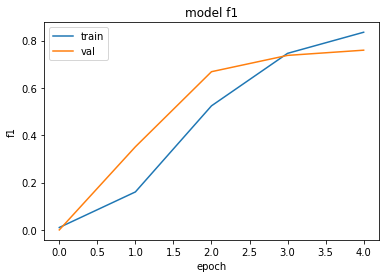

In [92]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

До этого мы разбирали сами слои и как-то не обращали внимание на результаты. А они получаются так себе. Видно, что есть переобучение.

Для борьбы с переобучением в нейронках есть регуляризация и Dropout. 

    Базовая регуляризация тут как в классических алгоритмах - l1 и l2. В большинстве слоев есть параметры smth_regularizer (можно строкой указать l1 или l2), где вместо smth какая-то специфичная часть слоя, которая обучается (kernel_regularizer в свертках  это регуляризация весов в матрицах).
    
    А Dropout - это отдельный слой, в котором часть подаваемых значений просто случайно зануляется. Это застявляет нейронку смотреть  на большее количество паттернов, а не переобучаться только на какой-то один.
 

In [105]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = tf.keras.layers.Dropout(0.1)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = tf.keras.layers.Dropout(0.1)(conv2) # это значит что случайно заменяется половина всех значений

concat = tf.keras.layers.Flatten()(drop2)
dense = tf.keras.layers.Dense(50, activation='relu', kernel_regularizer='l2')(concat)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [106]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 201)]             0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 201, 100)          5530600   
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 197, 32)           16032     
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 193, 32)           5152      
_________________________________________________________________
dropout_11 (Dropout)         (None, 193, 32)           0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 6176)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                308

In [107]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
71/71 [==============================] - 14s 178ms/step - loss: 0.5320 - f1: 0.0476 - val_loss: 0.1560 - val_f1: 0.2912
Epoch 2/10
71/71 [==============================] - 12s 168ms/step - loss: 0.1432 - f1: 0.4668 - val_loss: 0.2562 - val_f1: 0.4885
Epoch 3/10
71/71 [==============================] - 12s 170ms/step - loss: 0.1639 - f1: 0.6210 - val_loss: 0.1199 - val_f1: 0.6566
Epoch 4/10
71/71 [==============================] - 12s 170ms/step - loss: 0.1014 - f1: 0.7104 - val_loss: 0.2223 - val_f1: 0.6487
Epoch 5/10
71/71 [==============================] - 12s 169ms/step - loss: 0.1570 - f1: 0.6927 - val_loss: 0.1100 - val_f1: 0.6638
Epoch 6/10
71/71 [==============================] - 12s 169ms/step - loss: 0.0919 - f1: 0.7388 - val_loss: 0.0952 - val_f1: 0.6980
Epoch 7/10
71/71 [==============================] - 12s 168ms/step - loss: 0.0781 - f1: 0.7756 - val_loss: 0.1007 - val_f1: 0.6958
Epoch 8/10
71/71 [==============================] - 12s 169ms/step - loss: 0.0906 -

Переобучаться стало сильно меньше.

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


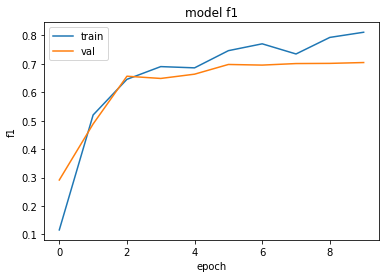

In [108]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Еще один параметр в сверточном слое - padding. Так как мы проходим каким-то окном по последовательности, на выходе последовательность сокращается. Но мы можем добавить нулей в начало и конец, чтобы на выходе было такое же число (padding='same').

Так мы можем наслаивать огромное количество слоев (она не уменьшается на каждом шаге).

А еще это позволяет, например, сделать вот такую сеть:

In [110]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

# мы делаем несколько параллельных сверточных слоев (даже пар слоев с пулингом) с разным окном
# но из-за того, что бы сделали паддинг, длинна получается одинаковая и мы можем сконкатенировать 
# векторы по второй размерности (так же как вы склеивали эбмединги от фастекста и ворд2века в предыдущей домашке)

for ks in [3,4,5,7,10]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

# а тут мы можем поставить еще свертку
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [111]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 201)]        0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 201, 100)     5530600     input_22[0][0]                   
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 201, 32)      9632        embedding_20[0][0]               
__________________________________________________________________________________________________
conv1d_37 (Conv1D)              (None, 201, 32)      12832       embedding_20[0][0]               
___________________________________________________________________________________________

In [112]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
71/71 [==============================] - 25s 321ms/step - loss: 1.4183 - f1: 0.0072 - val_loss: 0.4284 - val_f1: 0.0084
Epoch 2/5
71/71 [==============================] - 24s 337ms/step - loss: 0.3309 - f1: 0.1004 - val_loss: 0.1513 - val_f1: 0.5782
Epoch 3/5
71/71 [==============================] - 24s 344ms/step - loss: 0.1236 - f1: 0.6519 - val_loss: 0.0908 - val_f1: 0.7120
Epoch 4/5
71/71 [==============================] - 24s 342ms/step - loss: 0.0767 - f1: 0.7619 - val_loss: 0.0831 - val_f1: 0.7228
Epoch 5/5
71/71 [==============================] - 24s 338ms/step - loss: 0.0617 - f1: 0.8082 - val_loss: 0.0819 - val_f1: 0.7297


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


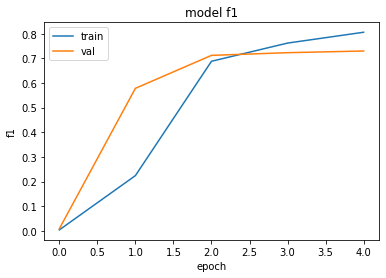

In [114]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

В Conv1D только один вариант паддинга - нулями. Но есть и другие способы (посмотрите лекцию по ссылке в начале). В функции tf.pad дает больше выбора паддинга. Его можно вставить в tf.keras.layers.Lambda, чтобы использовать в сети. 

Для текстов это наверное не так актуально, но при работе с картинками может пригодиться.

In [138]:
# пример
tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                        [[0,0], [1,1], [0,0]], 
                                        mode='CONSTANT'))

# x тут это то, что будет на входе, например последовательность эмбедингов
#
# второй параметр - это значения паддинга для каждой из размерности слева и справа

# у нас будут последовательности вида (batch_size, max_len, embedding_size)

# с размером батча ничего не делаем, поэтому [0, 0]

# длину последовательности меняем, она связана с kernel_size как раз и меняется - [1, 1], 
# т.е. паддим одну колонку слева и одну справа (была 134, станет 136, например)

# размер эмбединга тоже не трогаем, т.к. фильтра применяется на всю глубину
#

# mode - это тип паддинга, CONSTANT - это паддинг нулями
# еще есть SYMMETRIC, REFLECT

# вот примеры, как это работает

# tf.pad(t, paddings, "CONSTANT")  # [[0, 0, 0, 0, 0, 0, 0],
#                                  #  [0, 0, 1, 2, 3, 0, 0],
#                                  #  [0, 0, 4, 5, 6, 0, 0],
#                                  #  [0, 0, 0, 0, 0, 0, 0]]

# tf.pad(t, paddings, "REFLECT")  # [[6, 5, 4, 5, 6, 5, 4],
#                                 #  [3, 2, 1, 2, 3, 2, 1],
#                                 #  [6, 5, 4, 5, 6, 5, 4],
#                                 #  [3, 2, 1, 2, 3, 2, 1]]

# tf.pad(t, paddings, "SYMMETRIC")  # [[2, 1, 1, 2, 3, 3, 2],
#                                   #  [2, 1, 1, 2, 3, 3, 2],
#                                   #  [5, 4, 4, 5, 6, 6, 5],
#                                   #  [5, 4, 4, 5, 6, 6, 5]]

### Попробуйте подбирать паддинги, чтобы понять, как это работает, на игрушечном тензоре

In [139]:
x = [[[1,2,3],[3, 4,5]], [[6,7,8], [9,10, 11]]]

In [144]:
np.array(x)

array([[[ 1,  2,  3],
        [ 3,  4,  5]],

       [[ 6,  7,  8],
        [ 9, 10, 11]]])

In [146]:
np.array(x).shape

(2, 2, 3)

In [140]:
tf.pad(x, [[0, 0], [1, 1], [0, 0]])

<tf.Tensor: shape=(2, 4, 3), dtype=int32, numpy=
array([[[ 0,  0,  0],
        [ 1,  2,  3],
        [ 3,  4,  5],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 6,  7,  8],
        [ 9, 10, 11],
        [ 0,  0,  0]]], dtype=int32)>

Это еще не все сложности.

Понадобится ещё разобраться в том, как расчитывается размер выхода из свертки в зависимости от размера фильтра.

В лекции была такая формула -   
output = (shape-kernel_size)/stride + 1


Из неё нам нужно вывести размер паддинга с каждой стороны нашей матрицы. Для этого нам нужно найти такой shape, при котором выход из свертки будет равняться нашему текущему shape.   
shape = (X-kernel_size)/stride + 1

Потом его нужно разделить на 2 и получить размер паддинга с каждой стороны. 

Получается что-то такое -   
X = ((((shape - 1) * stride) + kernel_size) - shape) / 2 (может еще упрощается, но я давно не считал руками)

Тут еще нужно учесть, что не при любом значении kernel_size будут получаться четные числа, а это значит нужно будет паддить не ровно. Это вы можете доделать самостоятельно. Я просто взял значения kernel_size (3,5), при которых все сходится.

Еще небольшая проблема в том, что мы не можем задать сетку, как это делали выше (через цикл). Я не знаю, почему так, но если развернуть цикл и написать все без переменных, то работает.

In [129]:
# Паддинг для kernel_size=3
ks = 3
((((MAX_LEN - 1) * 1) + ks) -  MAX_LEN) / 2

1.0

In [130]:
# Паддинг для kernel_size=5
ks = 5
((((MAX_LEN - 1) * 1) + ks) -  MAX_LEN) / 2

2.0

In [115]:

inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []


# kernel_size = 3
pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=32, strides=1)(pad1)

pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [1,1], [0, 0]], 
                                               mode='REFLECT'))(conv1)

conv2 = tf.keras.layers.Conv1D(kernel_size=3, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad2)


#kernel_size = 5
pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(embeddings)

conv3 = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(pad3)

pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [2,2], [0, 0]], 
                                               mode='REFLECT'))(conv3)

conv4 = tf.keras.layers.Conv1D(kernel_size=5, filters=32,strides=1, 
                              kernel_regularizer='l2', activation='relu')(pad4)



concat = tf.keras.layers.concatenate([conv2, conv4])

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [116]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 201)]        0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 201, 100)     5530600     input_23[0][0]                   
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 203, 100)     0           embedding_21[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 205, 100)     0           embedding_21[0][0]               
___________________________________________________________________________________________

In [117]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=5)

Epoch 1/5
71/71 [==============================] - 17s 212ms/step - loss: 0.7792 - f1: 2.6767e-05 - val_loss: 0.3100 - val_f1: 0.0000e+00
Epoch 2/5
71/71 [==============================] - 15s 207ms/step - loss: 0.2570 - f1: 0.1484 - val_loss: 0.1517 - val_f1: 0.4862
Epoch 3/5
71/71 [==============================] - 15s 208ms/step - loss: 0.1313 - f1: 0.5529 - val_loss: 0.1043 - val_f1: 0.6510
Epoch 4/5
71/71 [==============================] - 15s 206ms/step - loss: 0.0909 - f1: 0.7038 - val_loss: 0.0882 - val_f1: 0.7033
Epoch 5/5
71/71 [==============================] - 15s 208ms/step - loss: 0.0721 - f1: 0.7719 - val_loss: 0.0845 - val_f1: 0.7213


dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


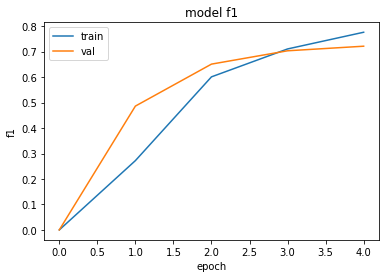

In [118]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Сохранение и загрузка модели

Когда какая-то модель получилась, её может потребоваться сохранить.

In [45]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


In [37]:
# сохраненную модель можно загрузить вот так, НО
# модель с метрикой ф1 не будет загружаться, так как она не стандартная
# model = tf.keras.models.load_model('model')

Можно сохранить только веса, но потом придется задать модель и только после этого загрузить веса.

In [46]:
model.save_weights('model.weights')

In [47]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)
concat = tf.keras.layers.concatenate(convs, axis=2)
conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [48]:
model.load_weights('model.weights')

## Callbacks

Еще есть такая штука как колбеки. С помощью них можно сохранять модель с лучшим результатом, останавливать обучение, если уже не обучается или менять learning_rate в зависимости от текущего состояния. С колбеками можно поставить нейронку обучаться и заняться какими-то другими делами, зная, что лучшие веса сохранятся.

Описание стандартных колбеков - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [22]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [23]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)
drop1 = tf.keras.layers.Dropout(0.3)(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=3, filters=128, strides=1, 
                                               kernel_regularizer='l2',
                                              activation='relu')(embeddings)
conv2 = tf.keras.layers.Conv1D(kernel_size=5, filters=128, strides=2, 
                                               kernel_regularizer='l2',
                                              activation='relu')(conv1)

drop2 = tf.keras.layers.Dropout(0.5)(conv2) # это значит что случайно заменяется половина всех значений

flatten = tf.keras.layers.Flatten()(drop2)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])


In [24]:

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10,
         callbacks=[checkpoint, early_stop])

Epoch 1/10
621/621 [==============================] - ETA: 0s - loss: 0.2668 - f1: 0.3060
Epoch 00001: val_f1 improved from -inf to 0.52367, saving model to model.weights
621/621 [==============================] - 65s 105ms/step - loss: 0.2668 - f1: 0.3060 - val_loss: 0.1307 - val_f1: 0.5237
Epoch 2/10
621/621 [==============================] - ETA: 0s - loss: 0.1262 - f1: 0.5597
Epoch 00002: val_f1 did not improve from 0.52367
621/621 [==============================] - 65s 105ms/step - loss: 0.1262 - f1: 0.5597 - val_loss: 0.1279 - val_f1: 0.5177
Epoch 3/10
621/621 [==============================] - ETA: 0s - loss: 0.1187 - f1: 0.5877
Epoch 00003: val_f1 improved from 0.52367 to 0.56685, saving model to model.weights
621/621 [==============================] - 65s 104ms/step - loss: 0.1187 - f1: 0.5877 - val_loss: 0.1242 - val_f1: 0.5669
Epoch 4/10
621/621 [==============================] - ETA: 0s - loss: 0.1142 - f1: 0.6055
Epoch 00004: val_f1 did not improve from 0.56685
621/621 [==

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


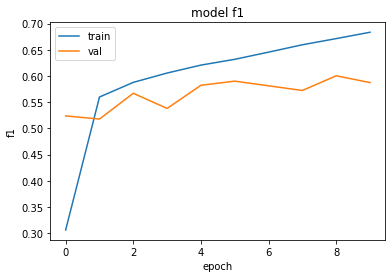

In [25]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Домашка


Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру. Должно получиться сопоставимое качество с моделями выше.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.
